# Aplicación de filtro de partículas a seguimiento visual

Actividad realizada por Sergio Hernández García para el curso de Introducción a los Métodos Bayesianos para la Inferencia Estadística 2022.

En este notebook se realiza un ejemplo básico de aplicación de los contenido vistos sobre filtro de partículas a un caso de seguimiento visual de una pelota.

In [35]:
import cv2
import os
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

La siguiente función nos permite visualizar las partículas

In [36]:
def print_particles(img, particulas, y_best = None, x_best = None, color=(0, 0, 255)):
    h, w = 30, 30
    if particulas:
        index = np.random.choice(range(len(particulas['estados'])), int(len(particulas['estados'])*0.5), replace=False)
        estados = particulas['estados'][index]
        peso_p = particulas['peso']*7 + 1

        for i in range(estados.shape[0]):
            y = estados[i, 0]
            x = estados[i, 1]
            img_copy = img.copy()
            img = cv2.circle(img, center=(int(x+w/2), int(y+h/2)), radius=int(peso_p[i]), color=(0, 255, 0), thickness=-1)

            alpha = 0.7  # Transparency factor.
            # Following line overlays transparent rectangle over the image
            img = cv2.addWeighted(img_copy, alpha, img, 1 - alpha, 0)

    if y_best and x_best:
        img = cv2.rectangle(img, (int(x_best-w/2), int(y_best-h/2)), (int(x_best + w/2), int(y_best + h/2)), color, 2)

    return img

In [37]:
ruta = "SecuenciaPelota"
ruta_img = [os.path.join(ruta, '{}.jpg'.format(i)) for i in range(1, 61)]

fondo = cv2.imread(ruta_img[0], cv2.IMREAD_GRAYSCALE)

In [38]:
n = 500
particulas = {'estados': np.zeros((n,2)),
              'peso': np.zeros(n)}

y_best, x_best = None, None

Con fines demostrativos, leemos el fotograma número 10.

In [104]:
frame_rgb = mpimg.imread(ruta_img[10])
frame = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2GRAY)  # Convertir imagen a escala de grises

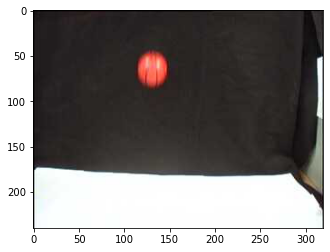

In [105]:
plt.imshow(frame_rgb)
plt.show()

## Mueatrear n partículas
En los primeros pasos muestreamos de una distribución uniforme para cubrir toda la imagen. Una ved se ha detectado el objeto a seguir, pasaremos a muestrear de una distribución Normal.

In [106]:
particulas['estados'] = np.random.rand(n, 2) * frame.shape[0]
particulas['estados'] = particulas['estados'].astype(int)

500.0


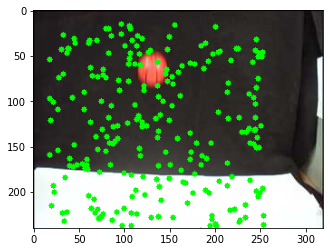

In [107]:
img_particles =  print_particles(frame_rgb, particulas)
plt.imshow(img_particles)
plt.show()

Para detectar la pelota, realizamos una sustracción de fondo.

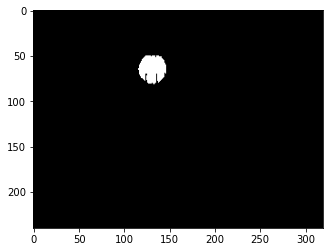

In [108]:
# Sustraccion de fondo
th = np.abs(np.float32(frame) - np.float32(fondo)) > 70
th = np.uint8(th * 255)
plt.imshow(th, cmap='gray')
plt.show()

Calculamos la likelihood de cada partícula. Para esto, realizamos un recuento del número de píxeles pertenecientes a la pelota que se encuentran dentro de un rectángulo de tamaño 30x30 con centro en las coordenadas de cada partícula.

In [109]:
h, w = 30, 30
estados = particulas['estados']

for i in range(estados.shape[0]):
    y = estados[i, 0]
    x = estados[i, 1]
    particulas['peso'][i] = np.sum(th[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)])

# Normalizamos los pesos
total = np.sum(particulas['peso'])
particulas['peso'] = particulas['peso']/total

Remuestreamos de la likelihood para seleccionar una partícula.

In [110]:
# Muestreamos con pesos=particulas['peso']
index = np.random.choice(range(n), p=particulas['peso'])
y_sample = particulas['estados'][index,0]
x_sample  = particulas['estados'][index,1]

print('x=', y_sample, ' y=', x_sample, ' peso=', particulas['peso'][index])

# Estas lineas de código nos muestran la partíocula más probable
index_best = np.argmax(particulas['peso'])
y_best = particulas['estados'][index_best,0]
x_best  = particulas['estados'][index_best,1]

print('x=', y_best, ' y=', x_best, ' peso=', particulas['peso'][index_best])

x= 68  y= 107  peso= 0.012942682406485564
x= 63  y= 133  peso= 0.09842127720096715


Mostramos la partícula remuestreada.

501.0


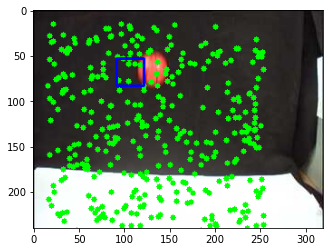

In [111]:
img_particles = print_particles(frame_rgb, particulas, y_sample, x_sample, color=(0, 0, 255))
plt.imshow(img_particles)
plt.show()

Mostramos la partícula con mayor likelihood.

501.0


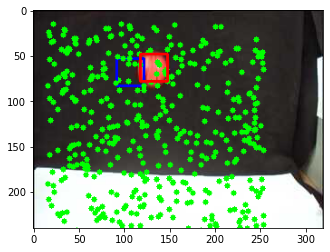

In [112]:
img_particles = print_particles(frame_rgb, particulas, y_best, x_best, color=(255, 0, 0))
plt.imshow(img_particles)
plt.show()

In [113]:
pesos_acum = particulas['peso']

for i in range(1, pesos_acum.shape[0]):
    pesos_acum[i] = pesos_acum[i-1] + pesos_acum[i]

random.seed(None)

for i in range(pesos_acum.shape[0]):
    rand = random.random()
    j = 0

    while j < pesos_acum.shape[0] and pesos_acum[j] < rand:
        j = j+1

    if j < pesos_acum.shape[0]:
        mu, sigma = 0, 10  # mean and standard deviation

        particulas['estados'][i,0] = particulas['estados'][j,0] + int(np.random.normal(mu, sigma))
        particulas['estados'][i,1] = particulas['estados'][j,1] + int(np.random.normal(mu, sigma))

In [39]:
def select_particles(particulas):

    y_best, x_best = select_best_particle(particulas)

    pesos_acum = particulas['peso']

    for i in range(1, pesos_acum.shape[0]):
        pesos_acum[i] = pesos_acum[i-1] + pesos_acum[i]

    random.seed(None)

    for i in range(pesos_acum.shape[0]):
        rand = random.random()
        j = 0

        while j < pesos_acum.shape[0] and pesos_acum[j] < rand:
            j = j+1

        if j < pesos_acum.shape[0]:
            mu, sigma = 0, 10  # mean and standard deviation

            particulas['estados'][i,0] = particulas['estados'][j,0] + int(np.random.normal(mu, sigma))
            particulas['estados'][i,1] = particulas['estados'][j,1] + int(np.random.normal(mu, sigma))

    return y_best, x_best

In [40]:
def calcular_pesos(img, particulas):
    h, w = 30, 30
    estados = particulas['estados']

    for i in range(estados.shape[0]):
        y = estados[i, 0]
        x = estados[i, 1]
        # particulas['peso'][i] = np.sum(img[y:y+h, x:x+w])
        particulas['peso'][i] = np.sum(img[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)])


    total = np.sum(particulas['peso'])

    if total != 0:
        particulas['peso'] = particulas['peso']/total

In [41]:
def select_best_particle(particulas):
    if np.sum(particulas['peso']) == 1:
        index = np.random.choice(range(n), p=particulas['peso'])
    # index = np.argmax(particulas['peso'])
    # if particulas['peso'][index] > 0:
        return particulas['estados'][index,0], particulas['estados'][index,1]
    else:
        return None, None

In [42]:
n = 200
particulas = {'estados': np.zeros((n,2)),
              'peso': np.zeros(n)}

y_best, x_best = None, None

In [74]:
video_frames = []
fourcc = cv2.VideoWriter_fourcc(*'XVID')
writer = cv2.VideoWriter('filtro_particulas.avi', fourcc, 25, (fondo.shape[1], fondo.shape[0]))
for img in ruta_img:
    frame_rgb = cv2.imread(img, cv2.IMREAD_COLOR)
    frame = cv2.cvtColor(frame_rgb, cv2.COLOR_BGR2GRAY)

    if not y_best and not x_best:
        particulas['estados'][:, 0] = np.random.rand(n) * frame.shape[0]
        particulas['estados'][:, 1] = np.random.rand(n) * frame.shape[1]
        particulas['estados'] = particulas['estados'].astype(int)

    # Sustraccion de fondo
    th = np.abs(np.float32(frame) - np.float32(fondo)) > 70
    th = np.uint8(th * 255)

    #calculo pesos
    calcular_pesos(th, particulas)

    y_best, x_best = select_particles(particulas)

    img_particles = print_particles(frame_rgb, particulas, y_best, x_best)
    # cv2.imshow('frame', img_particles)
    # cv2.waitKey(1)
    video_frames.append(img_particles)


for frame in video_frames:
    writer.write(frame)

writer.release()
    # plt.imshow(img_particles)
    # plt.draw()


In [75]:
from ipywidgets import Video, Image
from IPython.display import display
import numpy as np
import cv2
import base64

In [76]:
video = Video.from_file('filtro_particulas.avi')
video

Video(value=b'RIFF\x9a5\x03\x00AVI LIST\xec\x11\x00\x00hdrlavih8\x00\x00\x00@\x9c\x00\x00\x00S\x07\x00\x00\x00…

In [21]:
cap = cv2.VideoCapture('src/Big.Buck.Bunny.mp4')

frames = []

while(1):
    try:
        _, frame = cap.read()

        fgmask = cv2.Canny(frame, 100, 100)

        mask = fgmask > 100
        frame[mask, :] = 0

        frames.append(frame)
    except Exception:
        break

width = int(cap.get(3))
height = int(cap.get(4))

filename = 'src/output.mp4'

fourcc = cv2.VideoWriter_fourcc(*'avc1')
writer = cv2.VideoWriter(filename, fourcc, 25, (width, height))

for frame in frames:
    writer.write(frame)

cap.release()
writer.release()

with open(filename, 'rb') as f:
    video.value = f.read()

FileNotFoundError: [Errno 2] No such file or directory: 'src/output.mp4'